In [ ]:
# Download the single-cell sequencing data
!mkdir temporary_data
!mkdir temporary_data/example_codebook_design
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/matrix.mtx.gz -O temporary_data/example_codebook_design/matrix.mtx.gz
!gzip -d temporary_data/example_codebook_design/matrix.mtx.gz -f
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/features.tsv.gz -O temporary_data/example_codebook_design/features.tsv.gz
!gzip -d temporary_data/example_codebook_design/features.tsv.gz -f

In [1]:
# Input files
mtx_file = 'temporary_data/example_codebook_design/matrix.mtx'
features_file = 'temporary_data/example_codebook_design/features.tsv'
genes_of_interest_file = 'data/example_codebook_design/genes_Zhang_MOp.csv'
# Output file
cluster_sizes_file = 'temporary_data/example_codebook_design/cluster_sizes.npz'
cluster_gene_exp_file = 'temporary_data/example_codebook_design/cluster_gene_exp.npz'

In [2]:
import pandas as pd
import scanpy as sc

In [3]:
%%time
adata = sc.read_mtx(mtx_file)
adata = adata.transpose() # The matrix has to be transposed because the genes and cells are fipped

CPU times: user 17min 31s, sys: 16 s, total: 17min 47s
Wall time: 17min 35s


In [4]:
features = pd.read_csv(features_file, sep='\t', header=None)
adata.var['gene_ids'] = list(features[0])
adata.var['gene_symbols'] = list(features[1])
adata.var = adata.var.set_index('gene_symbols')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 176584 × 31053
    var: 'gene_ids'

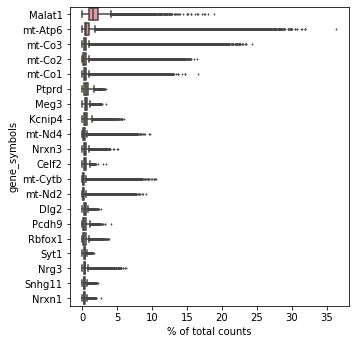

In [5]:
# Preprocessing
# Show the highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
# Save the raw state before cleaning the data
adata.raw = adata

In [7]:
# Filter out rare genes and cells express few genes
sc.pp.filter_cells(adata, min_genes=2000)
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 109217 × 25049
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [8]:
# annotate the group of mitochondrial genes as 'mt'
# High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), 
# possibly because of loss of cytoplasmic RNA from perforated cells.
adata.var['mt'] = adata.var_names.str.startswith('mt-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

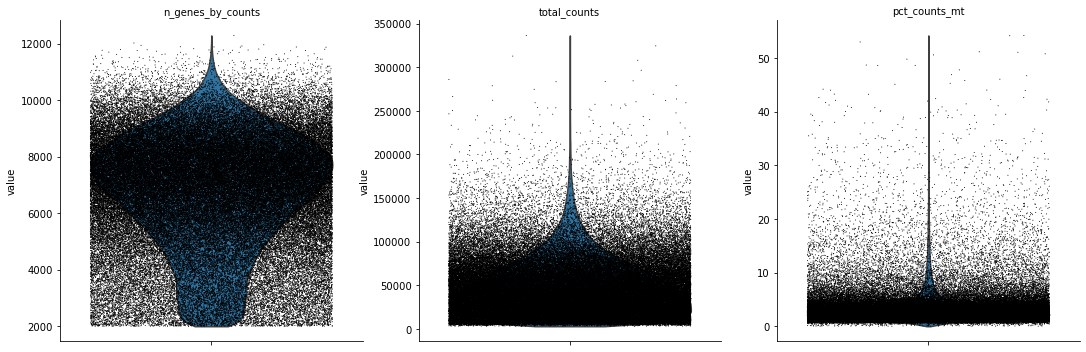

In [9]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
# - the percentage of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

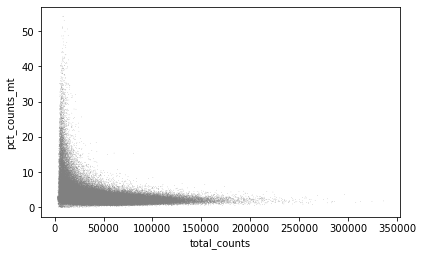

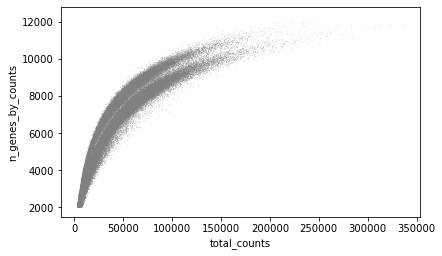

In [10]:
# Plot the distributions of gene counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
# Filter
adata = adata[adata.obs.n_genes_by_counts < 12000, :]
adata = adata[adata.obs.total_counts < 250000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [12]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
# Logarithmize the data
sc.pp.log1p(adata)

In [14]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

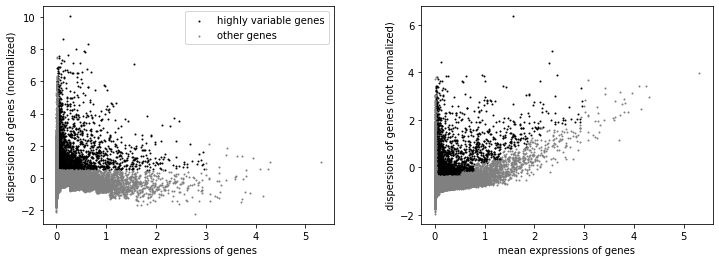

In [15]:
# Plot the highly variable genes
sc.pl.highly_variable_genes(adata)

In [16]:
# Filter out genes that are not highly variable
adata = adata[:, adata.var.highly_variable]

In [17]:
%%time
# Regress out effects of total counts per cell
sc.pp.regress_out(adata, ['total_counts'])

CPU times: user 24min 14s, sys: 1h 13min 50s, total: 1h 38min 5s
Wall time: 2min 10s


In [18]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [19]:
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')

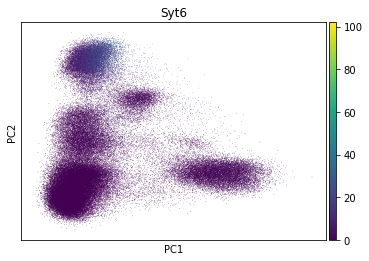

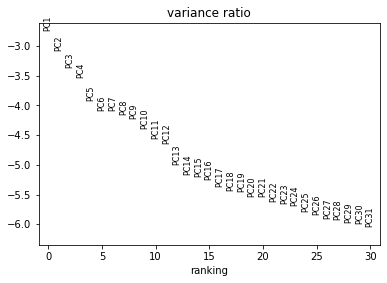

In [20]:
# Plot the PCA results
sc.pl.pca(adata, color='Syt6')
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

CPU times: user 41.3 s, sys: 38.2 s, total: 1min 19s
Wall time: 23.9 s


In [22]:
# Embed with UMAP
sc.tl.umap(adata)

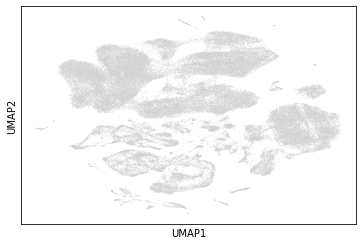

In [23]:
# Plot the UMAP
sc.pl.umap(adata)

In [24]:
# Clustering the neighborhood graph
sc.tl.leiden(adata)

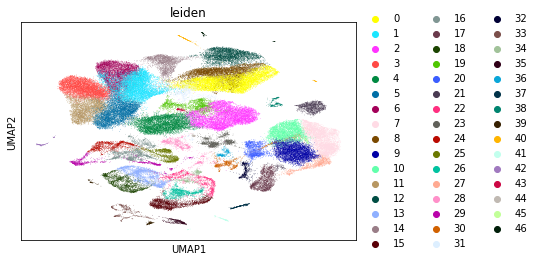

In [25]:
# Plot the clusters
sc.pl.umap(adata, color='leiden')

In [26]:
# Load the genes of interest
genes_zhang = pd.read_csv(genes_of_interest_file)
genes_of_interest = list(genes_zhang['gene'])

In [27]:
# Get the raw data without gene filtering
adata_raw = adata.raw.to_adata()

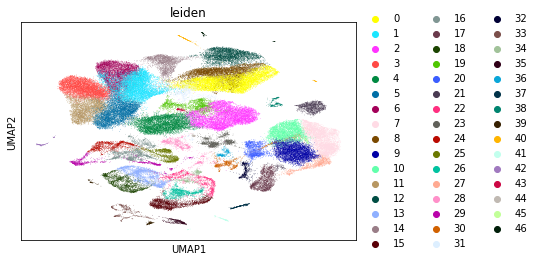

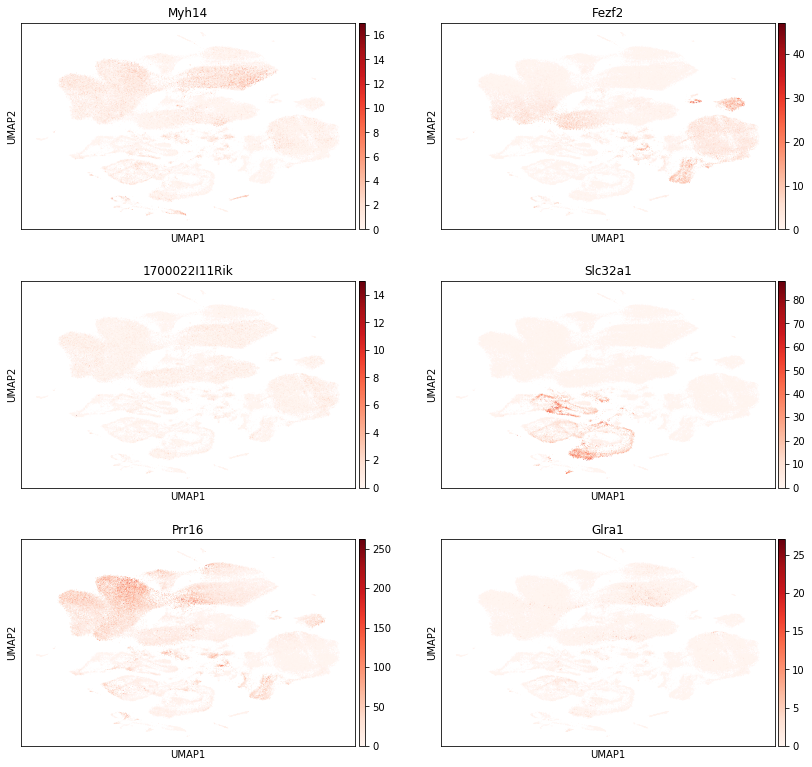

In [28]:
# Plot the expressions of a few random genes of interest
import numpy as np
sc.pl.umap(adata_raw, color='leiden', ncols=1)
sc.pl.umap(adata_raw, color=np.random.choice(genes_of_interest, size=6, replace=False), color_map='Reds', ncols=2)

In [29]:
# Get the cluster labels
cluster_labels = np.unique(np.array(adata_raw.obs['leiden']))
N_clusters = len(cluster_labels)
N_goi = len(genes_of_interest)

In [30]:
# Get the cluster sizes
cluster_sizes = [np.sum(adata_raw.obs['leiden'] == c_l) for c_l in cluster_labels]
cluster_sizes

[8239,
 7560,
 4016,
 3918,
 3609,
 2528,
 2267,
 2263,
 2002,
 1985,
 1824,
 1747,
 7231,
 1529,
 1501,
 1335,
 1306,
 1295,
 1265,
 1259,
 1155,
 1115,
 1034,
 6265,
 911,
 709,
 563,
 539,
 497,
 393,
 342,
 320,
 297,
 198,
 5811,
 179,
 167,
 137,
 129,
 98,
 89,
 75,
 5745,
 5071,
 4885,
 4805,
 4733]

In [31]:
%%time
# Calculate the expression matrix
# The matrix is N_clusters x N_genes
# Each element is the count of genes per million reads in the cluster
# NOTE: The 10x single cell sequencing only sequences the transcript terminals,
# so the counts should NOT be normalized by transcript lengths

# This simple implementation is slow. So speed it up by parallel processing
cluster_ids = list(range(N_clusters))

def fill_cluster_gene_exp(i):
    adata_cluster = adata_raw[adata_raw.obs['leiden'] == cluster_labels[i]]
    cluster_read_count = adata_cluster.X.sum()
    cluster_gene_exps = []
    
    for j in range(N_goi):
        adata_cg = adata_cluster[:, adata_cluster.var.index == genes_of_interest[j]]
        cg_read_count = adata_cg.X.sum()
        exp = cg_read_count / cluster_read_count * 10e6 # The expression has the unit of count per million
        cluster_gene_exps.append(exp)
    
    print('Finished cluster', cluster_labels[i])
    return cluster_gene_exps
        
from multiprocessing import Pool

with Pool(24) as p:
    cluster_gene_exp = np.array(p.map(fill_cluster_gene_exp, cluster_ids))
    

Finished cluster 29
Finished cluster 26
Finished cluster 25
Finished cluster 24
Finished cluster 22
Finished cluster 27
Finished cluster 19
Finished cluster 20
Finished cluster 28
Finished cluster 21
Finished cluster 18
Finished cluster 32
Finished cluster 35
Finished cluster 23
Finished cluster 37
Finished cluster 17
Finished cluster 40
Finished cluster 42
Finished cluster 34
Finished cluster 44
Finished cluster 33
Finished cluster 41
Finished cluster 39
Finished cluster 36
Finished cluster 31
Finished cluster 38
Finished cluster 46Finished cluster
 43
Finished cluster 45
Finished cluster 14
Finished cluster 30
Finished cluster 13
Finished cluster 16
Finished cluster 15
Finished cluster 12
Finished cluster 11
Finished cluster 10
Finished cluster 3
Finished cluster 7
Finished cluster 6
Finished cluster 8
Finished cluster 9
Finished cluster 2
Finished cluster 5
Finished cluster 1
Finished cluster 4
Finished cluster 0
CPU times: user 198 ms, sys: 684 ms, total: 882 ms
Wall time: 1min 22s

In [32]:
cluster_gene_exp

array([[1.76670392e+01, 2.40393456e+01, 7.87588377e-01, ...,
        2.09022372e+03, 1.57338684e+01, 4.71854946e+02],
       [1.77287598e+01, 3.68654764e+01, 4.31007123e-01, ...,
        9.96890740e+02, 5.05140360e+01, 2.25158128e+02],
       [1.95581038e+01, 3.68375936e+01, 1.10133010e+01, ...,
        1.38506497e+03, 1.49581520e+02, 1.18269563e+03],
       ...,
       [5.10103473e+01, 3.58062039e+01, 4.22837076e+00, ...,
        1.11943868e+03, 1.18619300e+02, 1.30913060e+03],
       [4.26752058e+01, 2.52628297e+01, 8.18530523e-01, ...,
        1.71329608e+03, 1.97563509e+01, 5.82830944e+02],
       [1.74024331e+01, 5.42218686e+01, 5.01498675e+00, ...,
        1.20222525e+03, 2.52463883e+01, 2.50367855e+03]])

Text(0.5, 0, 'log(expression + 1)')

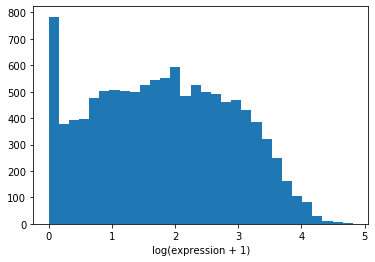

In [33]:
# Plot the distribution of expressions (count per million)
import matplotlib.pyplot as plt
plt.hist(np.log10(cluster_gene_exp.flatten() + 1), bins=30)
plt.xlabel('log(expression + 1)')

In [34]:
# Save the expression matrix
np.savez(cluster_gene_exp_file, cluster_gene_exp)
# Save the cluster sizes
np.savez(cluster_sizes_file, cluster_sizes)